# Imports

In [ ]:
# Install requirements from requirements file
%pip install -r ../requirements.txt

# Alternative: Install requirements directly
# %pip install blosum
# %pip install Bio
# %pip install torch torchvision torchaudio transformers sentencepiece accelerate --extra-index-url https://download.pytorch.org/whl/cu116
# %pip install protein-bert
# %pip install biopython biotite
# %pip install fair-esm
# %pip install scipy
# %pip install matplotlib
# %pip install seaborn

In [10]:
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import pandas as pd
import numpy as np
from scipy.stats import t
import blosum as bl
from Bio import SeqIO
import random
from scipy import stats
import torch
import esm
import re
import os
from tqdm import tqdm
import seaborn as sns
import re
import random
import pickle
import statistics
import time
from zipfile import ZipFile
import sys
sys.path.insert(0, "../")

# Importing models and embeddings retrieval methods
from models import get_model
from embeddings import get_fasta_embeddings, get_pair_embeddings, load_fasta

# Retrieve the device (CPU or GPU)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("Using device: {}".format(device))

torch.set_grad_enabled(False)

import warnings
warnings.filterwarnings("ignore")

# Available models
MODELS_LIST = ["ProtT5", "ProtBert", "ProtAlbert", "ProtXLNet", "ESM1b", "ESM2"]

# Available alignment types
ALIGNMENT_TYPES = ["Global-regular" , "Global-end-gap-free"]

c:\Users\Riley\iCloudDrive\Repositories\e-score\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cpu
Using device: cpu
Using device: cpu


# Alignment Algorithms

## Global

In [11]:
def affine_global_dp(seq_1, seq_2, g_open, g_ext,
                     scoring="ProtT5", Model=None, Model_tokenizer=None):
    """ Performs global alignment of two sequences using affine gap penalty dynamic programming algorithm """
    m, n = len(seq_1), len(seq_2)

    # Initialize matrices
    M = np.zeros([m + 1, n + 1])
    M[0, 1:] = g_open + g_ext * np.arange(0, n, 1)
    M[1:, 0] = g_open + g_ext * np.arange(0, m, 1)

    # Copies to avoid Gotoh's error
    L, U = np.copy(M), np.copy(M)
    L[1:, 0] += g_open;
    U[0, 1:] += g_open

    # Tracer matrix
    tracer = np.zeros([np.shape(M)[0], np.shape(M)[1], 7])
  
    # Get embeddings
    emb1, emb2 = get_pair_embeddings(seq_1, seq_2, Model, Model_tokenizer, scoring)
    cos = torch.nn.CosineSimilarity(dim=0)

    # Dynamic programming algorithm
    for i in range(1, m + 1):
        for j in range(1, n + 1):
            l_arr = np.array([M[i, j - 1] + g_open, L[i, j - 1] + g_ext])
            L[i, j] = np.max(l_arr)
            l_where = l_arr == np.max(l_arr)

            u_arr = np.array([M[i - 1, j] + g_open, U[i - 1, j] + g_ext])
            U[i, j] = np.max(u_arr)
            u_where = u_arr == np.max(u_arr)

            if scoring in MODELS_LIST:
                sim = cos(torch.tensor(emb1[i - 1], dtype=torch.float32), 
                          torch.tensor(emb2[j - 1], dtype=torch.float32)).item()
                m_arr = np.array([M[i - 1, j - 1] + sim, U[i, j], L[i, j]])

            M[i, j] = np.max(m_arr)
            m_where = m_arr == np.max(m_arr)

            idx = np.hstack([m_where, u_where, l_where])
            tracer[i, j, idx] = 1

    # Traceback
    alignment = traceback_g(tracer, seq_1, seq_2, affine=True)
    alignment = list(set(map(tuple, alignment)))

    return M, L, U, tracer, alignment


def traceback_g(tracer, seq_1, seq_2, mat=None, affine=False, roadmap=0):
    """ Performs traceback step of the sequence alignment algorithm - reconstructs aligned sequences from the tracer matrix 
    Based on Smith-Waterman algorithm
    """
    # Get sequence lengths
    m, n = len(seq_1), len(seq_2)

    # Convert to numpy arrays
    x = np.array(list(seq_1), dtype='object')
    y = np.array(list(seq_2), dtype='object')

    # Set start location
    st = [m + 1, n + 1]
    st_lv = 0  # Start in midgard

    while st[0] > 1 and st[1] > 1:
        B = np.zeros([2, 2])  # define 2x2 box which specifies which way to move

        Tr_size = 7 if affine else 3  # Size of tracer array
        Tr = np.zeros([Tr_size])  # define a Tr_size x 1 Tr array (will store arrows at each step)

        # Get tracer array
        for i in range(Tr_size):
            Tr[i] = np.copy(tracer[st[0] - 1, st[1] - 1, i])

        # Bifurcations
        levels = [[2, 0, 1], [4, 3], [6, 5]] if affine else [[2, 0, 1]]

        for l in levels:
            if np.sum(Tr[l]) > 1:
                choose = np.where(Tr[l] == 1)[0]
                Tr[l] = 0
                r = np.random.choice(choose, 1)[0] if roadmap == 0 else choose[-1] if roadmap == 1 else choose[0]
                if roadmap not in [0, 1, 2]:
                    raise Exception("roadmap only accepts 0: random turning, 1: highroad, 2: lowroad")
                Tr[l[r]] = 1

        # Diagonal
        if Tr[0] == 1 and st_lv == 0:
            B[0, 0] = 1

        # End gaps
        if Tr[1] == 1 and st_lv == 0:
            if affine:
                st_lv = 1  # level up
            else:
                B[0, 1] = 1

        if Tr[2] == 1 and st_lv == 0:
            if affine:
                st_lv = 2  # level down
            else:
                B[1, 0] = 1

        # Affine gaps allow for level shifts
        if affine:
            if Tr[4] == 1 and st_lv == 1:  # move up
                B[0, 1] = 1

            if Tr[3] == 1 and st_lv == 1:  # move up back to main
                st_lv = 0
                B[0, 1] = 1

            if Tr[6] == 1 and st_lv == 2:  # move left
                B[1, 0] = 1

            if Tr[5] == 1 and st_lv == 2:  # move left back to main
                st_lv = 0
                B[1, 0] = 1

        # Movements
        if B[0, 1] == 1:  # upward
            y = np.insert(y, st[1] - 1, '-')  # add a gap
            st[0] -= 1

        if B[1, 0] == 1:  # leftward
            x = np.insert(x, st[0] - 1, '-')  # add a gap
            st[1] -= 1

        if B[0, 0] == 1:  # diagonal
            st[1] -= 1
            st[0] -= 1

    # Some end gaps are left when you hit the upper/lower end of the matrix or a 0
    end_size = np.size(x) - np.size(y)  # how many gaps and for which sequence
    end_gap = ['-'] * abs(end_size)
    if end_size > 0:
        y = np.insert(y, 0, end_gap)
    elif end_size < 0:
        x = np.insert(x, 0, end_gap)

    # Check no overlapping gaps
    x = np.where(((x == '-') & (y == '-')), None, x)
    y = np.where((x == None), '', y)
    x = np.where((x == None), '', x)

    return np.sum(x), np.sum(y)

## Prefix/Suffix

In [12]:
def affine_semi_global_dp(seq_1, seq_2, g_open, g_ext,
                          high_low=False, scoring="ProtT5", Model=None, Model_tokenizer=None):
    """ Performs semi-global alignment of two sequences using affine gap penalty dynamic programming algorithm """
    m, n = len(seq_1), len(seq_2)
    
    # Initialize matrices
    M = np.zeros([m + 1, n + 1])
    L, U = np.copy(M), np.copy(M)

    # Tracer matrix
    tracer = np.zeros([np.shape(M)[0], np.shape(M)[1], 7])

    # Get embeddings
    emb1, emb2 = get_pair_embeddings(seq_1, seq_2, Model, Model_tokenizer, scoring)
    cos = torch.nn.CosineSimilarity(dim=0)

    # Dynamic programming algorithm
    for i in range(1, m + 1):
        for j in range(1, n + 1):
            l_arr = np.array([M[i, j - 1] + g_open, L[i, j - 1] + g_ext])
            L[i, j] = np.max(l_arr)
            l_where = l_arr == np.max(l_arr)

            u_arr = np.array([M[i - 1, j] + g_open, U[i - 1, j] + g_ext])
            U[i, j] = np.max(u_arr)
            u_where = u_arr == np.max(u_arr)

            if scoring in MODELS_LIST:
                sim = cos(torch.tensor(emb1[i - 1], dtype=torch.float32), 
                          torch.tensor(emb2[j - 1], dtype=torch.float32)).item()
                m_arr = np.array([M[i - 1, j - 1] + sim, U[i, j], L[i, j]])

            M[i, j] = np.max(m_arr)
            m_where = m_arr == np.max(m_arr)

            idx = np.hstack([m_where, u_where, l_where])
            tracer[i, j, idx] = 1

    alignment = [traceback_sg(tracer, seq_1, seq_2, mat=M, affine=True, local= True, roadmap=0)]
    alignment = list(set(map(tuple, alignment)))

    return M, L, U, tracer, alignment


def traceback_sg(tracer, seq_1, seq_2, mat=None, local=False, affine=False, roadmap=0):
    """ Performs traceback step of the sequence alignment algorithm - reconstructs aligned sequences from the tracer matrix """
    m, n = len(seq_1), len(seq_2)

    # Convert to numpy arrays
    x = np.array(list(seq_1), dtype='object')
    y = np.array(list(seq_2), dtype='object')

    # Set start location (random maxima if 0)
    r = np.random.choice(range(np.size(np.where(mat == np.max(mat))[0])), 1)[0] if roadmap == 0 else -1 if roadmap == 1 else 0
    st = [(np.where(mat == np.max(mat))[0][r]) + 1, (np.where(mat == np.max(mat))[1][r]) + 1]

    # Set starting gaps based on the start location
    start_size = (m - st[0]) - (n - st[1])  # how many gaps and for which sequence
    start_gap = (['-'] * abs(start_size))
    if start_size > 0:
        y = np.append(y, start_gap)
    elif start_size < 0:
        x = np.append(x, start_gap)

    st_lv = 0  # start in midgard

    while st[0] > 1 and st[1] > 1:
        B = np.zeros([2, 2])  # define 2x2 box which specifies which way to move

        Tr_size = 7 if affine else 3  # size of tracer array
        Tr = np.zeros([Tr_size])  # define a Tr_size x 1 Tr array (will store arrows at each step)

        # Tracer
        for i in range(Tr_size):
            Tr[i] = np.copy(tracer[st[0] - 1, st[1] - 1, i])

        # Bifurcations
        levels = [[2, 0, 1], [4, 3], [6, 5]] if affine else [[2, 0, 1]]

        for l in levels:
            if np.sum(Tr[l]) > 1:
                choose = np.where(Tr[l] == 1)[0]
                Tr[l] = 0
                # 0: random turning, 1: highroad, 2: lowroad
                r = np.random.choice(choose, 1)[0] if roadmap == 0 else choose[-1] if roadmap == 1 else choose[0]
                if roadmap not in [0, 1, 2]:
                    raise Exception("roadmap only accepts 0: random turning, 1: highroad, 2: lowroad")
                
                Tr[l[r]] = 1

        # level up-down
        if Tr[0] == 1 and st_lv == 0:  # diagonal
            B[0, 0] = 1

        if Tr[1] == 1 and st_lv == 0:
            if affine:
                st_lv = 1  # level up
            else:
                B[0, 1] = 1

        if Tr[2] == 1 and st_lv == 0:
            if affine:
                st_lv = 2  # level down
            else:
                B[1, 0] = 1

        # Affine gaps allow for level shifts
        if affine:
            if Tr[4] == 1 and st_lv == 1:  # move up
                B[0, 1] = 1

            if Tr[3] == 1 and st_lv == 1:  # move up back to main
                st_lv = 0
                B[0, 1] = 1

            if Tr[6] == 1 and st_lv == 2:  # move left
                B[1, 0] = 1

            if Tr[5] == 1 and st_lv == 2:  # move left back to main
                st_lv = 0
                B[1, 0] = 1

        if local and mat[st[0] - 1, st[1] - 1] == 0:
            break

        # Movements
        if B[0, 1] == 1:  # upward
            y = np.insert(y, st[1] - 1, '-')  # add a gap
            st[0] -= 1

        if B[1, 0] == 1:  # leftward
            x = np.insert(x, st[0] - 1, '-')  # add a gap
            st[1] -= 1

        if B[0, 0] == 1:  # diagonal
            st[1] -= 1
            st[0] -= 1

    # Some end gaps are left when you hit the upper/lower end of the matrix or a 0
    end_size = np.size(x) - np.size(y)  # how many gaps and for which sequence
    end_gap = (['-'] * abs(end_size))
    if end_size > 0:
        y = np.insert(y, 0, end_gap)
    elif end_size < 0:
        x = np.insert(x, 0, end_gap)

    # Check no overlapping gaps
    x = np.where(((x == '-') & (y == '-')), None, x)
    y = np.where((x == None), '', y)
    x = np.where((x == None), '', x)

    return np.sum(x), np.sum(y)

# Aux Funx

In [13]:
def get_sequences_only(seqs):
    """ Extracts a list of (sequence) from a list of (name, sequence) tuples """
    return [seq[1] for seq in seqs]

def aligned_to_indexed(seqs):
  """ Removes dashes (-) in a sequence and creates positions array for non-dash residues """
  # Replace dashes with empty string
  no_dash = [seq.replace("-", "") for seq in seqs]

  # Create positions array for non-dash residues
  positions = [[i for i, char in enumerate(seq) if char != "-"] for seq in seqs]

  return no_dash, positions

def length_matcher(x , y , place = ""):
  """ Matches the length between x and y with spaces if necessary """
  length = 5

  def add_spaces(value):
    spaces = abs(len(value) - length)
    return " " * spaces + value if place == "Back" else value + " " * spaces

  return add_spaces(x), add_spaces(y)

# Alignment Computations

In [14]:
def get_alignments(prot1, prot2, gap_penalty = 0, gap_extension_penalty = 0,
                   scoring = "ProtT5", alignment_type = "Global-regular", Model = "", Model_Tokenizer = ""):
  """ Gets the alignments between two sequences """
  
  if alignment_type == "Global-regular":
    M, L, U, tracer, alignment = affine_global_dp(prot1, prot2, gap_penalty, gap_extension_penalty, 
                                                  scoring = scoring , Model = Model, Model_tokenizer = Model_Tokenizer)
    max_score = np.max(M)

  if alignment_type == "Global-end-gap-free" or alignment_type == "End-Gap-Free":
    M, L, U, tracer, alignment = affine_semi_global_dp(prot1, prot2, gap_penalty, gap_extension_penalty, 
                                                        scoring = scoring , Model = Model, Model_tokenizer = Model_Tokenizer)
    max_score = max(M[-1,-1],L[-1,-1],U[-1,-1])

  # Return (reference alignment, query alignment, alignment score)
  aligned1 = alignment[0][0]
  aligned2 = alignment[0][1]

  return aligned1, aligned2, max_score

In [15]:
def get_visualization(prot1, prot2, score, Type = "", Model = "", Model_Tokenizer = ""):
  MODELS_LIST = ["ProtT5" , "ProtBert" , "ProtAlbert" , "ProtXLNet" , "ESM1b" , "ESM2"]
  cos = torch.nn.CosineSimilarity(dim=0)

  seqs = [prot1 , prot2]
  no_dash, positions = aligned_to_indexed(seqs)

  # Get embeddings
  p1_emb, p2_emb = get_pair_embeddings(no_dash[0], no_dash[1], Model, Model_Tokenizer, Type)

  p1_revived = ""
  p2_revived = ""
  aligned_info = ""

  for i in range(len(prot1)):
    if i in positions[0]:
      p1_revived += prot1[i]
    else:
      p1_revived += "-"

    if i in positions[1]:
      p2_revived += prot2[i]
    else:
      p2_revived += "-"


    if p1_revived[-1] == p2_revived[-1]:
      aligned_info += p1_revived[-1]
    elif p1_revived[-1] == "-" or p2_revived[-1] == "-":
      aligned_info += " "
    elif p1_revived[-1] != p2_revived[-1]:
      if Type in MODELS_LIST:
        sim = cos(torch.tensor(p1_emb[0][positions[0].index(i)] , dtype = torch.float32) ,
                  torch.tensor(p2_emb[0][positions[1].index(i)] , dtype = torch.float32)).item()
        aligned_info += " "

  del model
  del tokenizer

  return p1_revived, aligned_info, p2_revived, score

# Alignment For 2 Sequences

In [16]:
def alignment_file_TXT(saving_add, seqs_path, scoring, alignment_type,
                      gap_penalty, gap_extension_penalty):
  """ Creates and outputs the alignment file between two sequences """
  print(f"Device: {device}")

  # Get selected model
  Model , Model_Tokenizer = get_model(scoring)

  # Load sequences from FASTA file
  seqs = load_fasta(seqs_path)

  # Get protein sequences
  prot1 = seqs[0][1]
  prot2 = seqs[1][1]

  # Get names of protein sequences
  name1 = seqs[0][0]
  name2 = seqs[1][0]

  # Get alignments and visualization
  reference_al, query_al, al_score = get_alignments(prot1, prot2, gap_penalty = gap_penalty,
                                              gap_extension_penalty = gap_extension_penalty ,
                                              scoring = scoring , alignment_type = alignment_type,
                                              Model = Model , Model_Tokenizer = Model_Tokenizer)

  p1_al , aligned_info , p2_al , al_score = get_visualization(reference_al , query_al, al_score , Type = scoring,
                                                              Model = Model, Model_Tokenizer = Model_Tokenizer)

  if not os.path.exists(saving_add):
    os.makedirs(saving_add)

  file_name = saving_add + seqs_path.split("/")[-1].split(".")[-2] + "_" + scoring + "_" + alignment_type + "_"
  file_name += str(gap_penalty) + "_" + str(gap_extension_penalty) + "_"+ "Alignment" + ".txt"
  f = open(file_name, "w")

  # Write Sequence 1 Information
  f.write("Seq 1 \n")
  f.write(">" + name1 + "\n")
  f.write(reference_al.replace("-" , "") + "\n")
    
  # Write Sequence 2 Information
  f.write("Seq 2 \n")
  f.write(">" + name2 + "\n")
  f.write(query_al.replace("-" , "") + "\n\n")
    
  # Write Alignment Information
  f.write("Alignment Type : " + alignment_type + "\n\n")
  f.write("Opening Gap Penalty : " + str(gap_penalty) + "\n")
  f.write("Extension Gap Penalty : " + str(gap_extension_penalty) + "\n")
  f.write("Scoring System : " + scoring + "\n")
  f.write("Score : "  + str(al_score) + "\n\n")

  p1_pos = 1
  p2_pos = 1
  aligned_gaps = ""

  for j in range(int(len(p1_al) / 60) + 1):
    p1_posix = p1_al[j * 60: (j + 1) * 60]
    p2_posix = p2_al[j * 60: (j + 1) * 60]
    p1_back_str, p2_back_str = length_matcher(str(p1_pos) , str(p2_pos) , place = "Front")

    for k in range(len(p1_posix)):
      if p1_posix[k] != "-":
        p1_pos += 1
      if p2_posix[k] != "-":
        p2_pos += 1

    p1_end_str, p2_end_str = length_matcher(str(p1_pos - 1) , str(p2_pos - 1) , place = "Back")
    aligned_gaps = " " * len(p1_back_str)

    f.write("Seq 1 : " + p1_back_str + " " + p1_al[j * 60: (j + 1) * 60] + " " + p1_end_str + "\n")
    f.write("        "  +  aligned_gaps + " " + aligned_info[j * 60: (j + 1) * 60] + "\n")
    f.write("Seq 2 : "  + p2_back_str + " " + p2_al[j * 60: (j + 1) * 60] + " " + p2_end_str + "\n\n")

  print("Alignment Computation is Done!")
  del Model
  del Model_Tokenizer

# Cosine Similarity

In [35]:
def get_cosine_similarities(emb1, emb2, input = "embeddings", model = None, tokenizer = None, scoring = None):
    """ Gets the cosine similarity between two sequences 

    Args
        emb1, emb2 - either embeddings or sequences of the two proteins
        input (optional) - whether the input is sequences or embeddings
        model (optional) - model to use for embedding retrieval
        tokenizer (optional) - tokenizer to use for embedding retrieval
        scoring (optional) - scoring system to use for embedding retrieval
    
    Returns
        cosine_similarities - cosine similarity between the two sequences for the dimensions of the embeddings
    """
    if input == 'sequences':
        print(len(emb1))
        emb1, emb2 = get_pair_embeddings(emb1, emb2, model, tokenizer, scoring)
        print(len(emb1))
    
    cos = torch.nn.CosineSimilarity(dim=0)

    m, n = len(emb1), len(emb2)
    cosine_similarities = np.zeros([m, n])

    for i in range(m):
        for j in range(n):
            cosine_similarities[i, j] = cos(torch.tensor(emb1[i], dtype=torch.float32), 
                      torch.tensor(emb2[j], dtype=torch.float32)).item()
            
    return cosine_similarities

## Guide

In [29]:
def user_guide(MODELS_LIST):
  """ User guide for the E-score program """
  print("Parameters & Descriptions:")
  print("  saving_add:".ljust(25) + "Output directory path")
  print("  seqs_path:".ljust(25) + "FASTA file with two protein sequences")
    
  print("  scoring_type:".ljust(25) + "Model for embedding production (", end = "")
  for model_name in MODELS_LIST[:-1] : print(model_name + ", " , end = "")
  print(MODELS_LIST[-1] + ")")

  print("  alignment_type:".ljust(25) + "Global-regular or Global-end-gap-free")
  print("  gap_penalty:".ljust(25) + "Default: -1.0 | Recommended Values: -4.0, -3.0, -2.0, -1.5, -1.0, -0.5")
  print("  gap_extension_penalty:".ljust(25) + "Default: -0.2 | Recommended Values: -1.0, -0.8, -0.5, -0.3, -0.2, -0.1")

In [18]:
user_guide(MODELS_LIST)

Parameters & Descriptions:
  saving_add:            Output directory path
  seqs_path:             FASTA file with two protein sequences
  scoring_type:          Model for embedding production (ProtT5, ProtBert, ProtAlbert, ProtXLNet, ESM1b, ESM2)
  alignment_type:        Global-regular or Global-end-gap-free
  gap_penalty:           Default: -1.0 | Recommended Values: -4.0, -3.0, -2.0, -1.5, -1.0, -0.5
  gap_extension_penalty: Default: -0.2 | Recommended Values: -1.0, -0.8, -0.5, -0.3, -0.2, -0.1


# Analysis

In [52]:
# Testing Data Initialization
saving_add = "./analysis/"
seqs_path = "../data/uniprot_AGEVLEDQ.fasta"
scoring = MODELS_LIST[0] # ProtT5
alignment_type = ALIGNMENT_TYPES[0] # Global

model, tokenizer = get_model(scoring)
embeddings = get_fasta_embeddings(seqs_path, model, tokenizer, scoring)

Initializing ProtT5
Generating T5 Embeddings


## Embeddings

### Running Analysis on Sample Data

Initializing ProtT5
Generating T5 Embeddings
Initializing ProtBert
Initializing ProtAlbert


pytorch_model.bin: 100%|██████████| 897M/897M [00:12<00:00, 72.5MB/s] 


Initializing ProtXLNet


(…)lab/prot_xlnet/resolve/main/spiece.model: 100%|██████████| 238k/238k [00:00<00:00, 4.76MB/s]
(…)tlab/prot_xlnet/resolve/main/config.json: 100%|██████████| 1.35k/1.35k [00:00<?, ?B/s]
pytorch_model.bin: 100%|██████████| 1.64G/1.64G [00:59<00:00, 27.4MB/s]


Initializing ESM1b


Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm1b_t33_650M_UR50S.pt" to C:\Users\Riley/.cache\torch\hub\checkpoints\esm1b_t33_650M_UR50S.pt
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/regression/esm1b_t33_650M_UR50S-contact-regression.pt" to C:\Users\Riley/.cache\torch\hub\checkpoints\esm1b_t33_650M_UR50S-contact-regression.pt


Initializing ESM2


Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm2_t33_650M_UR50D.pt" to C:\Users\Riley/.cache\torch\hub\checkpoints\esm2_t33_650M_UR50D.pt
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/regression/esm2_t33_650M_UR50D-contact-regression.pt" to C:\Users\Riley/.cache\torch\hub\checkpoints\esm2_t33_650M_UR50D-contact-regression.pt


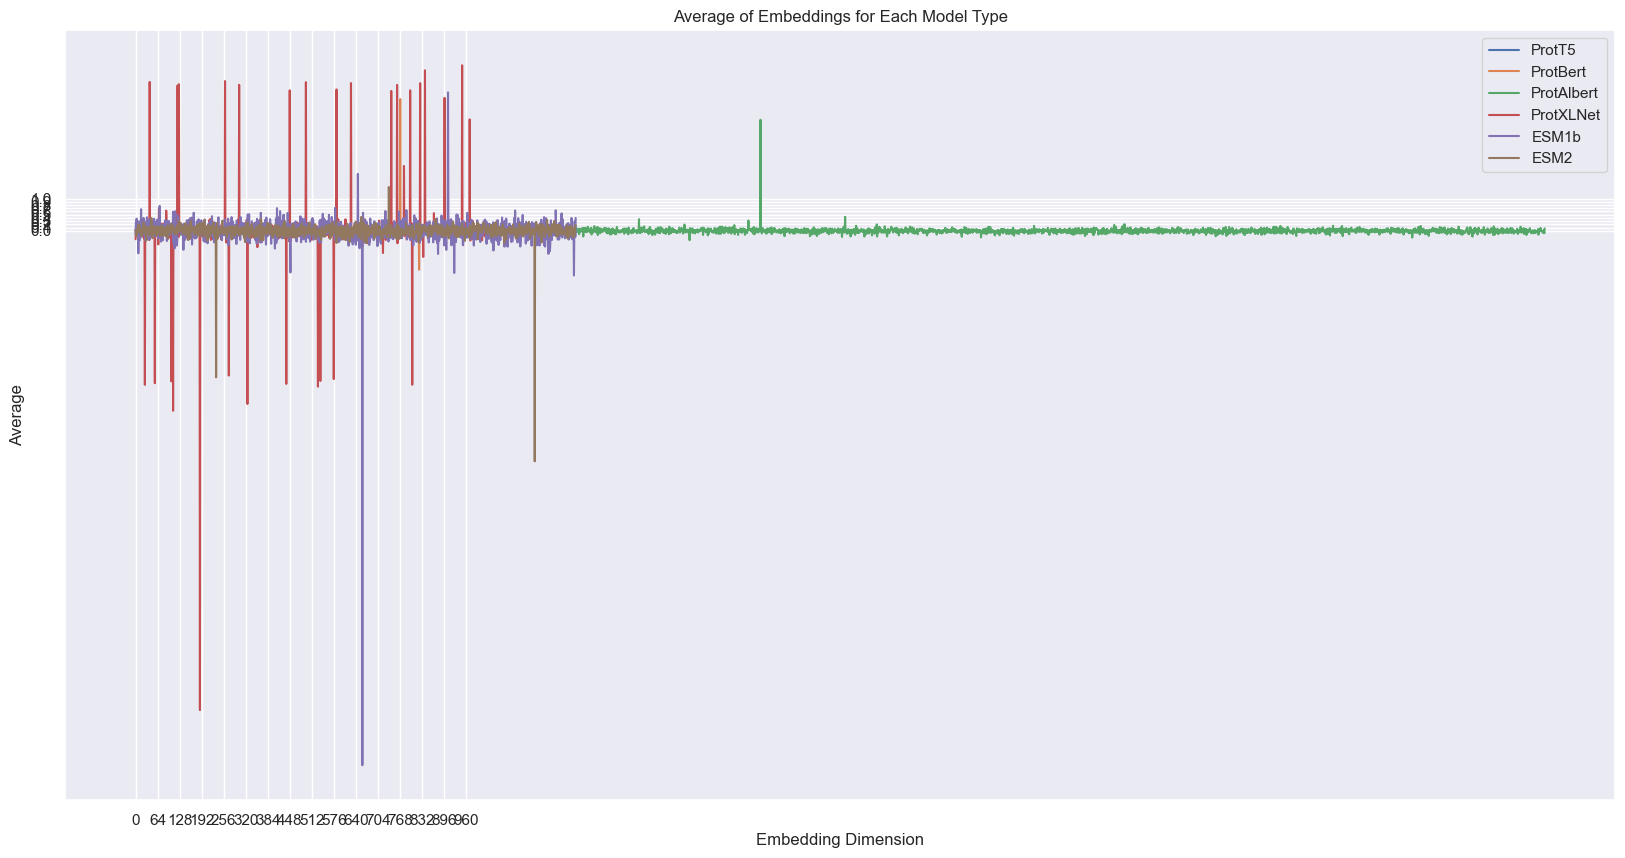

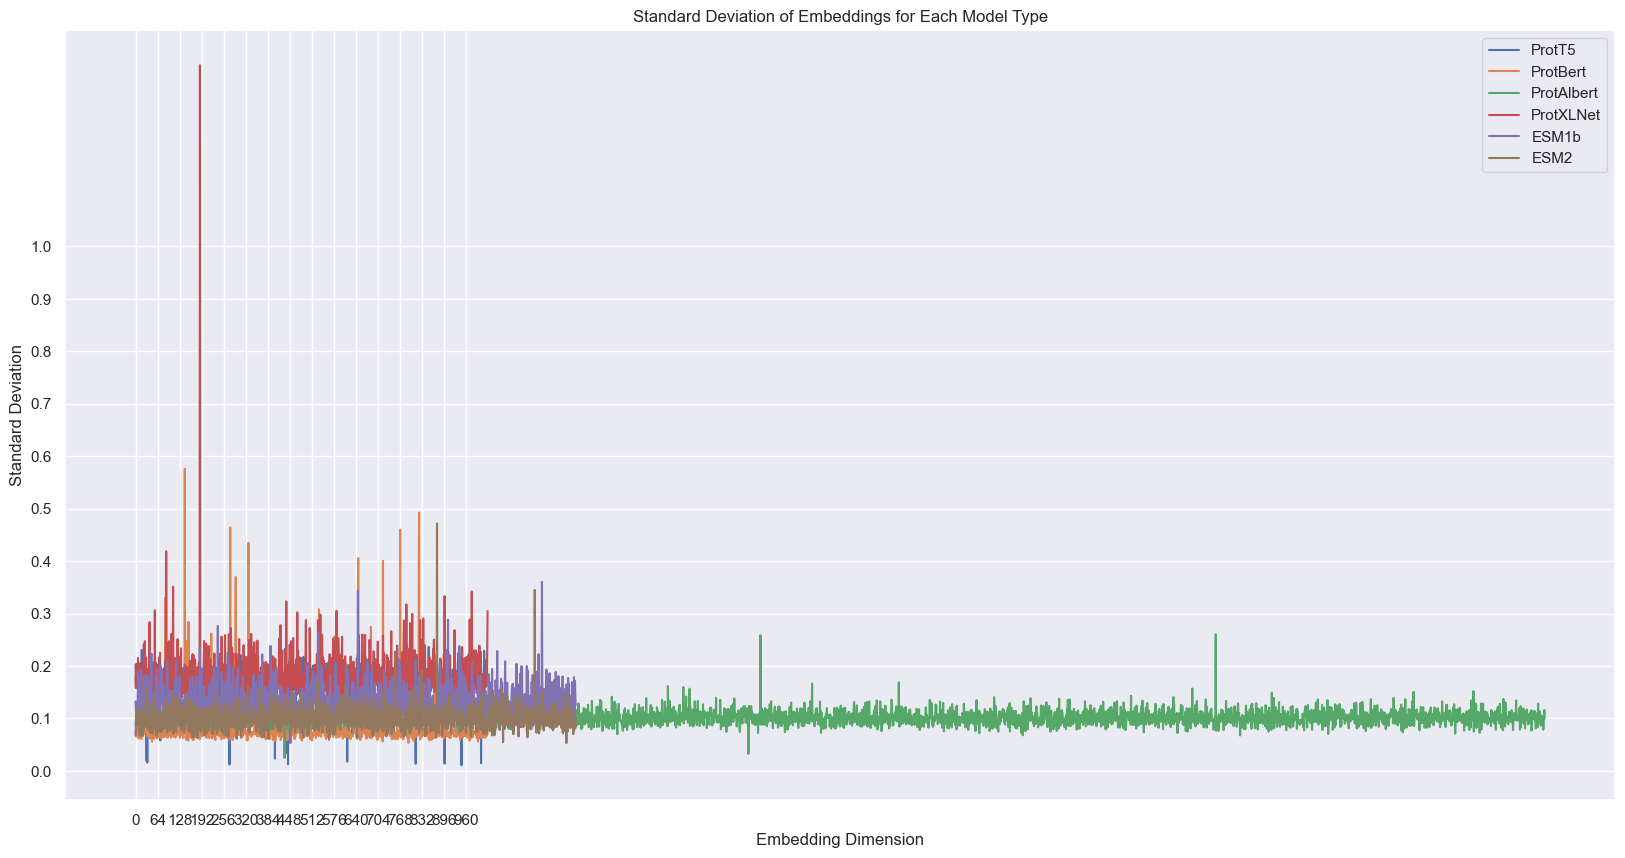

In [56]:
# Get the average and standard deviation for each embedding generated by each model type and visualize the differences
avg_map = {model: 0 for model in MODELS_LIST}
std_map = {model: 0 for model in MODELS_LIST}

for model_name in MODELS_LIST:
    model, tokenizer = get_model(model_name)
    embeddings = get_fasta_embeddings(seqs_path, model, tokenizer, model_name)
    for i in range(len(embeddings)):
        avg_map[model_name] += np.mean(embeddings[i], axis=0)
        std_map[model_name] += np.std(embeddings[i], axis=0)
    avg_map[model_name] /= len(embeddings)
    std_map[model_name] /= len(embeddings)

# Visualize the differences in the average and standard deviation of each embedding generated by each model type

# Average
plt.figure(figsize=(20, 10))
plt.title("Average of Embeddings for Each Model Type")
plt.xlabel("Embedding Dimension")
plt.ylabel("Average")
plt.xticks(range(0, 1024, 64))
plt.yticks(np.arange(-2, 2, 0.1))
for model_name in MODELS_LIST:
    sns.lineplot(x=range(len(avg_map[model_name])), y=avg_map[model_name], label=model_name)
plt.legend()
plt.show()

# Standard Deviation
plt.figure(figsize=(20, 10))
plt.title("Standard Deviation of Embeddings for Each Model Type")
plt.xlabel("Embedding Dimension")
plt.ylabel("Standard Deviation")
plt.xticks(range(0, 1024, 64))
plt.yticks(np.arange(0, 1.1, 0.1))
for model_name in MODELS_LIST:
    sns.lineplot(x=range(len(std_map[model_name])), y=std_map[model_name], label=model_name)
plt.legend()
plt.show()
    

## Cosine Similarity

### Running Analysis on Sample Data

Average cosine similarity: 0.05391280361138439
Standard deviation of cosine similarity: 0.10568064401834552
Average cosine similarity per dimension: [[0.         0.00019024 0.00017831 0.00019447 0.00018918 0.00023412
  0.00026345 0.00023323]
 [0.00019024 0.         0.00117983 0.00118904 0.00119066 0.00121901
  0.00103459 0.00121323]
 [0.00017831 0.00117983 0.         0.00117594 0.00118159 0.0012168
  0.00105119 0.00121382]
 [0.00019447 0.00118904 0.00117594 0.         0.00118774 0.00122055
  0.0010457  0.00121426]
 [0.00018918 0.00119066 0.00118159 0.00118774 0.         0.0012239
  0.00104139 0.0012189 ]
 [0.00023412 0.00121901 0.0012168  0.00122055 0.0012239  0.
  0.00143484 0.00158432]
 [0.00026345 0.00103459 0.00105119 0.0010457  0.00104139 0.00143484
  0.         0.00143609]
 [0.00023323 0.00121323 0.00121382 0.00121426 0.0012189  0.00158432
  0.00143609 0.        ]]
Standard deviation of cosine similarity per dimension: [[0.         0.00064782 0.00063759 0.00064933 0.00064348 0.00

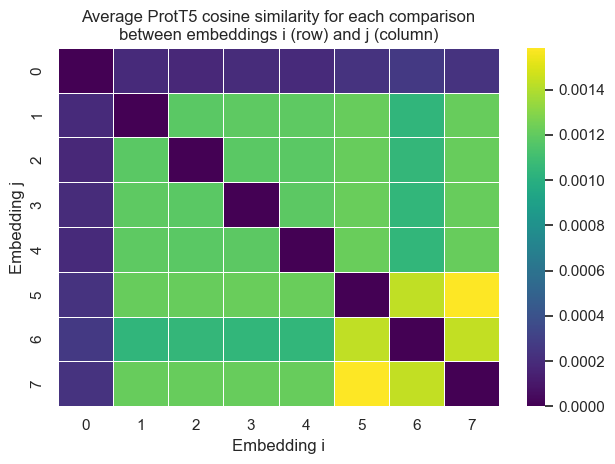

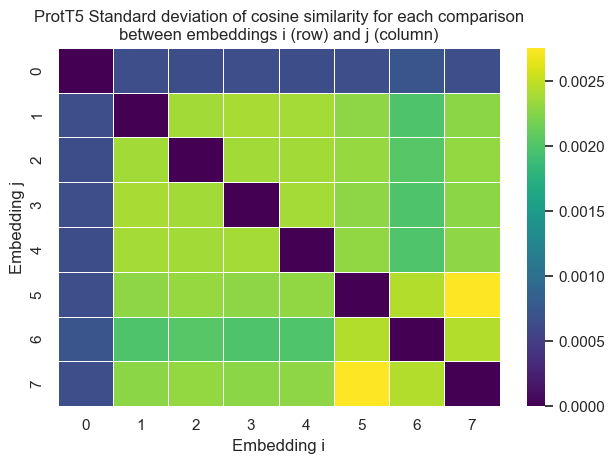

In [53]:
# Retrieve average and standard deviation results for cosine similarity
num_embeddings = len(embeddings)
running_avg = 0
running_std = 0
avg_per_dim = np.zeros([num_embeddings, num_embeddings])
std_per_dim = np.zeros([num_embeddings, num_embeddings])

# Compare every pair of embeddings
for i in range(num_embeddings):
    for j in range(num_embeddings):
        # Skip comparing it to itself
        if i == j: continue

        # Get cosine similarities
        cosine_similarities = get_cosine_similarities(embeddings[i], embeddings[j], 'embeddings')

        # Update running average and standard deviation
        running_avg += np.mean(cosine_similarities)
        running_std += np.std(cosine_similarities)
        avg_per_dim[i, j] += np.mean(cosine_similarities)
        std_per_dim[i, j] += np.std(cosine_similarities)

# Divide to update and get the average and standard deviation
running_avg /= num_embeddings * (num_embeddings - 1)
running_std /= num_embeddings * (num_embeddings - 1)

# Divide to update the dimensional average and standard deviation results
for i in range(num_embeddings):
    for j in range(num_embeddings):
        # Skip comparing it to itself
        if i == j: continue

        # Divide to get the average and standard deviation
        avg_per_dim[i, j] /= num_embeddings * (num_embeddings - 1)
        std_per_dim[i, j] /= num_embeddings * (num_embeddings - 1)

print("Average cosine similarity: {}".format(running_avg))
print("Standard deviation of cosine similarity: {}".format(running_std))

# Set the print options to disable truncation
np.set_printoptions(threshold=np.inf)

print("Average cosine similarity per dimension: {}".format(avg_per_dim))
print("Standard deviation of cosine similarity per dimension: {}".format(std_per_dim))

# Visualization
sns.set(font_scale=1)
avg_heatmap = sns.heatmap(avg_per_dim, cmap='viridis', linewidths=.5)
avg_heatmap.set_xlabel('Embedding i')
avg_heatmap.set_ylabel('Embedding j')
plt.title('Average ' + scoring + ' cosine similarity for each comparison\nbetween embeddings i (row) and j (column)')
plt.tight_layout()
plt.show()

std_heatmap = sns.heatmap(std_per_dim, cmap='viridis', linewidths=.5)
std_heatmap.set_xlabel('Embedding i')
std_heatmap.set_ylabel('Embedding j')
plt.title(scoring + ' Standard deviation of cosine similarity for each comparison\nbetween embeddings i (row) and j (column)')
plt.tight_layout()
plt.show()